In [8]:
from time import time
import os, sys, csv
import numpy as np
from pylab import *
import pylab as pylab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches
from MulticoreTSNE import MulticoreTSNE as TSNE
from scipy import stats


from kpal.klib import Profile

import pandas as pd


from sklearn import manifold
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn import svm
import umap
from sklearn.datasets import load_digits
from Bio import SeqIO
from io import StringIO
import sys

digits = load_digits()
digits.target

array([0, 1, 2, ..., 8, 9, 8])

In [5]:
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='euclidean').fit_transform(digits.data)

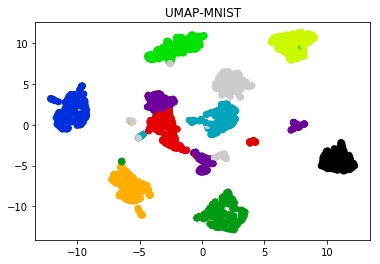

In [3]:
colors = [int(i % 10) for i in digits.target]
pylab.scatter(embedding[:,0], embedding[:,1],c=colors,cmap=pylab.cm.spectral)
pylab.title("UMAP-MNIST")
pylab.show()

In [13]:
tsne = TSNE(n_components=3, metric='euclidean',n_jobs=4)
t_embedding = tsne.fit_transform(digits.data)

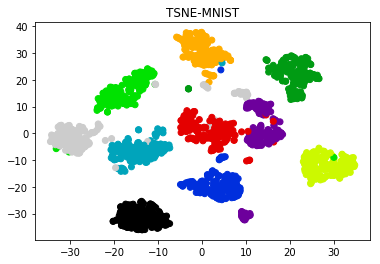

In [5]:
colors = [int(i % 10) for i in digits.target]
pylab.scatter(t_embedding[:,0], t_embedding[:,1],c=colors,cmap=pylab.cm.spectral)
pylab.title("TSNE-MNIST")
pylab.show()

In [14]:
TX_train, TX_test, Ty_train, Ty_test = train_test_split(t_embedding, digits.target, test_size=0.4, random_state=0)
UX_train, UX_test, Uy_train, Uy_test = train_test_split(embedding, digits.target, test_size=0.4, random_state=0)

In [15]:
Uclf = svm.SVC(kernel='linear', C=1).fit(UX_train, Uy_train)
Tclf = svm.SVC(kernel='linear', C=1).fit(TX_train, Ty_train)

In [16]:
print(Uclf.score(UX_test,Uy_test), Tclf.score(TX_test,Ty_test))

(0.9582753824756607, 0.9888734353268428)


In [69]:
Uclf_scores = []
Tclf_scores = []
for i in range(50):
    embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(digits.data)
    tsne = TSNE(n_jobs=4)
    t_embedding = tsne.fit_transform(digits.data)
    TX_train, TX_test, Ty_train, Ty_test = train_test_split(t_embedding, digits.target, test_size=0.4)
    UX_train, UX_test, Uy_train, Uy_test = train_test_split(embedding, digits.target, test_size=0.4)
    Uclf = svm.SVC(kernel='linear', C=1).fit(UX_train, Uy_train)
    Tclf = svm.SVC(kernel='linear', C=1).fit(TX_train, Ty_train)
    Uclf_scores.append(Uclf.score(UX_test,Uy_test))
    Tclf_scores.append(Tclf.score(TX_test, Ty_test))
    
print("Uclf mean score: ", mean(Uclf_scores))
print("Tclf mean score: ", mean(Tclf_scores))

Uclf mean score:  0.9497913769123784
Tclf mean score:  0.9467315716272603


In [70]:
F,p = stats.f_oneway(Uclf_scores, Tclf_scores)

In [71]:
F

0.5876988650443558

In [72]:
p

0.4451531283806819

# Haven't really run this bad boy. I was gonna test KNN classification accuracy but it turns out I don't care

In [ ]:
knn_2_scores = []
knn_5_scores = []
for i in range(50):
    embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(digits.data)
    tsne = TSNE(n_jobs=4)
    t_embedding = tsne.fit_transform(digits.data)
    TX_train, TX_test, Ty_train, Ty_test = train_test_split(t_embedding, digits.target, test_size=0.4)
    UX_train, UX_test, Uy_train, Uy_test = train_test_split(embedding, digits.target, test_size=0.4)
    Uclf = svm.SVC(kernel='linear', C=1).fit(UX_train, Uy_train)
    Tclf = svm.SVC(kernel='linear', C=1).fit(TX_train, Ty_train)
    Uclf_scores.append(Uclf.score(UX_test,Uy_test))
    Tclf_scores.append(Tclf.score(TX_test, Ty_test))

# Looking like a pretty insignificant result there. Let's try with another dataset...

Here I'm going to be using kPAL, the python kmer frequency vector generation library. Lots of this code is pulled from EukRep (https://github.com/patrickwest/EukRep/blob/master/EukRep/EukRep.py).
The data I'll be using is a simulated metagenome from the original MaxBin paper (https://microbiomejournal.biomedcentral.com/articles/10.1186/2049-2618-2-26). You can find it if you dig. I'll make labels soon enough.

In [6]:
def calc_kmer_freqs(split_seqs, kmer_size):
    '''
    Use kpal to calculate kmer frequencies for split sequences
    '''

    kmer_freqs = []
    for seq in split_seqs:
        temp_list = []

        #for some reason this kmer counter function only works on iterable(str) type objects.
        temp_list.append(str(seq))
        ktable = Profile.from_sequences(temp_list, kmer_size, name=None)

        #skip sequences with a lot of Ns/characters besides A|T|C|G
        if len(str(seq)) < 3000:
            if ktable.total >= len(str(seq))/2:
                ktable.counts = [count/ktable.total for count in ktable.counts]
                kmer_freqs.append(ktable.counts)
        else:
            if ktable.total >= 1500:
                ktable.counts = [count/ktable.total for count in ktable.counts]
                kmer_freqs.append(ktable.counts)

    return kmer_freqs

def chunk_sequence(sequence, min_size, max_size):
    '''
    Cut sequences longer than 5kb into 5kb chunks and exclude trailing sequences
    if shorter than user specified min_length
    '''

    split_seqs = []
    while True:
        chunk = sequence.read(max_size)
        if len(chunk) >= min_size:
            split_seqs.append(chunk)
        else:
            break

    return split_seqs

/home/jacob/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Let's get a label list so we can color these guys properly and see how they separate out.

In [6]:
ordered_genome_labels = {'AP011170.1':0,
                         """ Acetobacter pasteurianus; 
                             Bacteria; Proteobacteria; Alphaproteobacteria; Rhodospirillales;
                             Acetobacteraceae; Acetobacter"""
                         
                        'NC_016001.1':1,\
                         """Flavobacterium branchiophilum FL-15;
                            Bacteria; Bacteroidetes; Flavobacteriia; Flavobacteriales;
                            Flavobacteriaceae; Flavobacterium."""
                         
                        'NC_013422.1':2,\
                         """Halothiobacillus neapolitanius;
                            Bacteria; Proteobacteria; Gammaproteobacteria; Chromatiales;
                            Halothiobacillaceae; Halothiobacillus."""
                         
                        'CP002618.1':3,\
                         """Lactobacillus casei;
                         Bacteria; Firmicutes; Bacilli; Lactobacillales; Lactobacillaceae;
                         Lactobacillus."""
                         
                        'CP002086.1':4,\
                         """Nitrosococcus watsonii;
                         Bacteria; Proteobacteria; Gammaproteobacteria; Chromatiales;
                         Chromatiaceae; Nitrosococcus."""
                         
                        'NC_015160.1':5,\
                         """Odoribacter splanchnicus;
                         Bacteria; Bacteroidetes; Bacteroidia; Bacteroidales;
                         Odoribacteraceae; Odoribacter."""
                         
                        'NC_008268.1':6,\
                         """Rhodococcus jostii
                         Bacteria; Actinobacteria; Corynebacteriales; Nocardiaceae;
                         Rhodococcus."""
                         
                        'NC_010582.1':7,\
                         """S. pneumoniae CGSP14
                         Bacteria; Firmicutes; Bacilli; Lactobacillales; Streptococcaceae;
                         Streptococcus."""
                         
                        'NC_014538.1':8,\
                         """Thermoanaerobacter X513
                         Bacteria; Firmicutes; Clostridia; Thermoanaerobacterales;
                         Thermoanaerobacteraceae; Thermoanaerobacter."""
                         
                         """Xanthobacter autotrophicus
                        Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales;
                        Xanthobacteraceae; Xanthobacter."""
                        'NC_009720.1':9}
                        


aln_blast = pd.read_csv('/home/jacob/Documents/Jacob/Sim_Genomes/concat_blastn/sim_metagenome_blastlog',\
                        delimiter='\t', header=None)

FileNotFoundError: File b'/home/jacob/Documents/Jacob/Sim_Genomes/concat_blastn/sim_metagenome_blastlog' does not exist

In [6]:
aln_blast.columns = ['qseqid', 'sseqid', 'pident', 'evalue', 'bitscore']
aln_blast_100 = aln_blast[aln_blast['pident'] == 100.000]
aln_blast_100.head()

,qseqid,sseqid,pident,evalue,bitscore
0,NODE_1_length_83949_cov_75.226173,dbj|AP011170.1|,100.0,0.000000e+00,155100.0
2,NODE_1_length_83949_cov_75.226173,dbj|AP011170.1|,100.0,1.080000e-14,87.9
3,NODE_1_length_83949_cov_75.226173,dbj|AP011170.1|,100.0,1.080000e-14,87.9
4,NODE_1_length_83949_cov_75.226173,dbj|AP011170.1|,100.0,1.080000e-14,87.9
5,NODE_1_length_83949_cov_75.226173,dbj|AP011170.1|,100.0,3.900000e-14,86.1


In [5]:
#Make a list of unique contigs
#unique_contig_names = aln_blast.qseqid.unique()
if not os.path.exists('contig_labels.npy'):
    contig_labels = []

    real_contig_list = []
    for record in SeqIO.parse('/home/jacob/Documents/Jacob/Maxbin_Simulated_80x_metagenome.scaffold.fasta', "fasta"):
        real_contig_list.append(record.id)

    #Contigs don't show up in blast log at all; I'm assuming assembly errors. Label them with 0 and be done with it.
    stupid_list = []
    for contig in real_contig_list:
        if contig not in unique_contig_names:
            stupid_list.append(contig)

    for index, contig in enumerate(real_contig_list):
        #Take rows of dataframe corresponding to 
        if contig not in stupid_list:
            aln_blast_contig = aln_blast[aln_blast.qseqid == contig]
            aln_blast_contig_sorted = aln_blast_contig.sort_values(by=['bitscore'])
            try:
                origin_genome = aln_blast_contig_sorted['sseqid'].iloc[0].split('|')[1]
            except:
                print(index)
                print(contig)
                print(aln_blast_contig)
                print(aln_blast_contig_sorted['sseqid'].iloc[0])

            label = ordered_genome_labels[origin_genome]
            contig_labels.append(label)
        else:
            contig_labels.append(0)
        contig_labels = np.array(contig_labels)
        np.save('contig_labels.npy', contig_labels)
else:
    contig_array = np.load('contig_labels.npy')
    contig_labels = contig_array


In [9]:
#i=0
#real_contig_num = [contig.split('_')[-1] for contig in real_contig_list]
#unique_contig_num = [contig.split('_')[-1] for contig in unique_contig_names]

len(contig_array)

15701

In [4]:
max_size = 5000
min_size = 1000


#15701 contigs in simulated metagenome; use 5-mers for vector generation
if not os.path.exists('pentamer.npy'):
    pentamer_list = []
    for record in SeqIO.parse('/home/jacob/Documents/Jacob/Maxbin_Simulated_80x_metagenome.scaffold.fasta', "fasta"):
        s = StringIO(str(record.seq))
        split_seqs = []
        kmer_freqs = []
        seq_name = record.id

        #split sequence into 5kb max_size chunks
        #split_seqs = chunk_sequence(s, min_size, max_size)

        #Calculate kmer frequences for each chunk
        #kmer_freqs = calc_kmer_freqs(seq_name, 5)
        temp_list = []

        #for some reason this kmer counter function only works on iterable(str) type objects.
        temp_list.append(str(record.seq))
        ktable = Profile.from_sequences(temp_list, 5, name=None)

        ktable.counts = [count/ktable.total for count in ktable.counts]
        pentamer_list.append(ktable.counts)
        pentamer_array = np.array(pentamer_list)

else:
    pentamer_array = np.load('pentamer.npy')

In [22]:
for i in range(1,len(pentamer_list)):
    if len(pentamer_list[i]) != len(pentamer_list[i-1]):
        print("WHOMP WHOMP")
        print(len(pentamer_list[i]))
        print(len(pentamer_list[i-1]))

In [29]:
u_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation').fit_transform(pentamer_array)

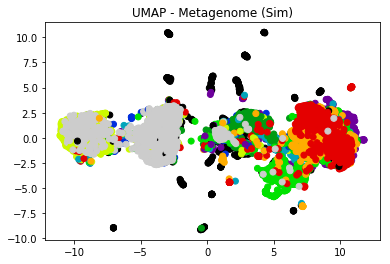

In [30]:
colors = [int(i % 10) for i in contig_labels]
pylab.scatter(u_embedding[:,0], u_embedding[:,1],c=colors,cmap=pylab.cm.spectral)
pylab.title("UMAP - Metagenome (Sim)")
pylab.show()

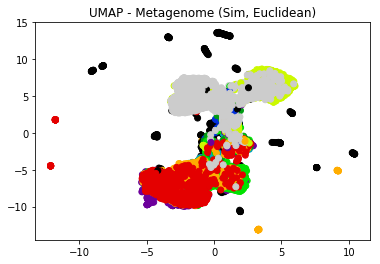

In [32]:
u_euc_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='euclidean').fit_transform(pentamer_array)
colors = [int(i % 10) for i in contig_labels]
pylab.scatter(u_embedding[:,0], u_embedding[:,1],c=colors,cmap=pylab.cm.spectral)
pylab.title("UMAP - Metagenome (Sim, Euclidean)")
pylab.show()

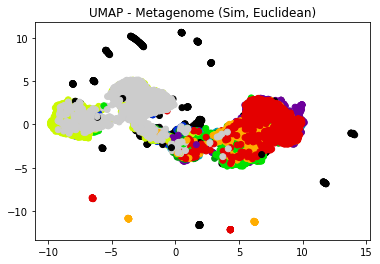

In [33]:
u_mink_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='minkowski').fit_transform(pentamer_array)
colors = [int(i % 10) for i in contig_labels]
pylab.scatter(u_embedding[:,0], u_embedding[:,1],c=colors,cmap=pylab.cm.spectral)
pylab.title("UMAP - Metagenome (Sim, Minkowski)")
pylab.show()

In [6]:
tsne = TSNE(n_components=3,n_jobs=4)
t_embedding = tsne.fit_transform(pentamer_array)

In [7]:
t_embedding.shape

(15701, 3)

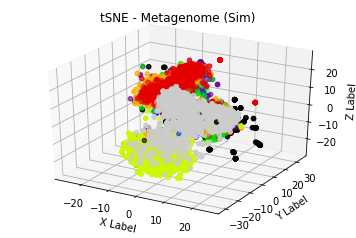

In [8]:
#pylab.scatter(t_embedding[:,0], t_embedding[:,1],c=colors,cmap=pylab.cm.spectral)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cmspec = plt.get_cmap("nipy_spectral")

ax.scatter(t_embedding[:,0], \
              t_embedding[:,1], \
              t_embedding[:,2], \
              c=contig_labels, cmap=cmspec)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

pylab.title("tSNE - Metagenome (Sim)")
pylab.show()

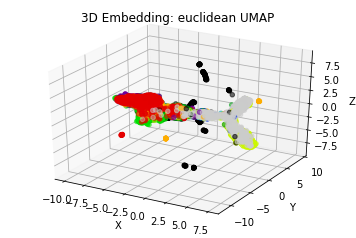

In [9]:
def umap_embed_3(neighbors, metric):
    u_embedding = umap.UMAP(n_components=3,
                            n_neighbors=neighbors,
                            min_dist=0.3,
                            metric=metric).fit_transform(pentamer_array)
    return u_embedding

def tsne_embed_3():
    tsne = TSNE(n_components=3,n_jobs=8)
    t_embedding = tsne.fit_transform(pentamer_array)
    return t_embedding

def plot_meta_3(embedding, metric, method):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    cmspec = plt.get_cmap("nipy_spectral")

    ax.scatter(embedding[:,0], \
              embedding[:,1], \
              embedding[:,2], \
              c=contig_labels, cmap=cmspec)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    pylab.title("3D Embedding: " + method + " " + metric)
    pylab.show()
    return

u_embedding = umap_embed_3(10, 'euclidean')
t_embedding = tsne_embed_3()
plot_meta_3(u_embedding, 'UMAP', 'euclidean')

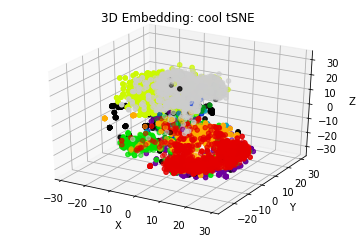

In [10]:
plot_meta_3(t_embedding, 'tSNE', 'cool')

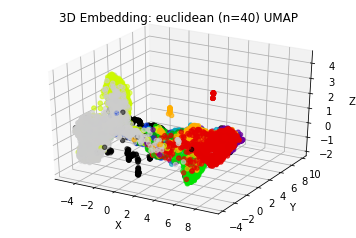

In [11]:
u_embedding = umap_embed_3(40, 'euclidean')
plot_meta_3(u_embedding, 'UMAP', 'euclidean (n=40)')

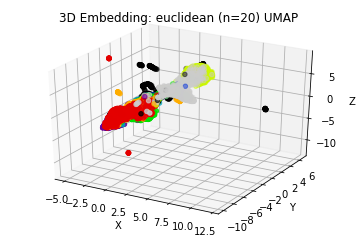

0.8465456860872334


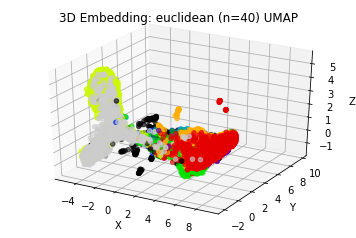

0.8373129576567973


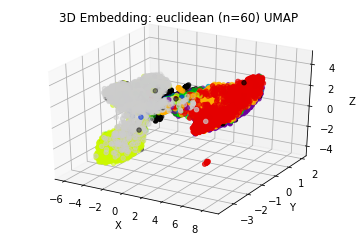

0.8360394778732888


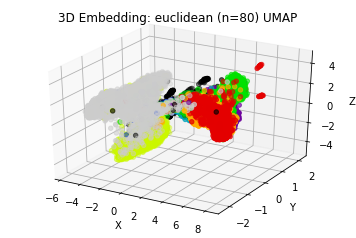

0.8446354664119707


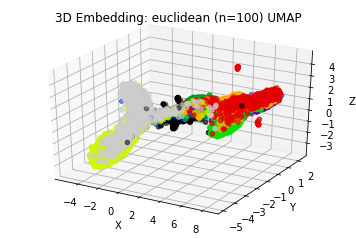

0.8468640560331104


In [14]:
umap_embed_list = []
def train_and_score(em, test_size, kernel):
    X_train, X_test, y_train, y_test = train_test_split(em, contig_labels, test_size=test_size)
    Uclf = svm.SVC(kernel=kernel, C=1).fit(X_train, y_train)
    return Uclf.score(X_test,y_test)
for i in range(5):
    u_embedding = umap_embed_3(20+20*i, 'euclidean')
    plot_meta_3(u_embedding, 'UMAP', 'euclidean (n='+str(20+20*i)+')')
    print(train_and_score(u_embedding, 0.2, 'rbf'))

/home/jacob/anaconda3/lib/python3.6/site-packages/umap/umap_.py:764: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn('Failed to correctly find n_neighbors for some samples.'
/home/jacob/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/jacob/anaconda3/lib/python3.6/site-packages/umap/umap_.py:1147: RuntimeWarning: invalid value encountered in less
  graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0


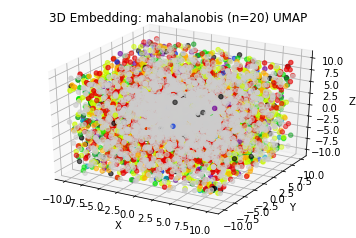

0.31964342566061765


In [ ]:
def train_and_score(em, test_size, kernel):
    X_train, X_test, y_train, y_test = train_test_split(em, contig_labels, test_size=test_size)
    Uclf = svm.SVC(kernel=kernel, C=1).fit(X_train, y_train)
    return Uclf.score(X_test,y_test)
for i in range(5):
    u_embedding = umap_embed_3(20+20*i, 'mahalanobis')
    plot_meta_3(u_embedding, 'UMAP', 'mahalanobis (n='+str(20+20*i)+')')
    print(train_and_score(u_embedding, 0.2, 'rbf'))

In [ ]:
def train_and_score(em, test_size, kernel):
    X_train, X_test, y_train, y_test = train_test_split(em, contig_labels, test_size=test_size)
    Uclf = svm.SVC(kernel=kernel, C=1).fit(X_train, y_train)
    return Uclf.score(X_test,y_test)
for i in range(5):
    u_embedding = umap_embed_3(20+20*i, 'manhattan')
    plot_meta_3(u_embedding, 'UMAP', 'manhattan (n='+str(20+20*i)+')')
    print(train_and_score(u_embedding, 0.2, 'rbf'))

In [ ]:
def train_and_score(em, test_size, kernel):
    X_train, X_test, y_train, y_test = train_test_split(em, contig_labels, test_size=test_size)
    Uclf = svm.SVC(kernel=kernel, C=1).fit(X_train, y_train)
    return Uclf.score(X_test,y_test)
for i in range(5):
    u_embedding = umap_embed_3(20+20*i, 'correlation')
    plot_meta_3(u_embedding, 'UMAP', 'correlation (n='+str(20+20*i)+')')
    print(train_and_score(u_embedding, 0.2, 'rbf'))

In [15]:
print(train_and_score(t_embedding, 0.2, 'rbf'))

0.8720152817574021


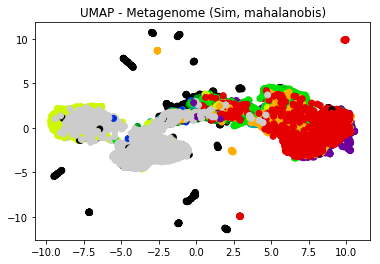

In [13]:
def umap_embed(neighbors, metric):
    u_embedding = umap.UMAP(n_neighbors=10,
                          min_dist=0.3,
                          metric='minkowski').fit_transform(pentamer_array)
    return u_embedding

def tsne_embed_fun():
    tsne = TSNE(n_jobs=4)
    return tsne.fit_transform(pentamer_array)

def plot_meta(u_embedding, metric):
    colors = [int(i % 10) for i in contig_labels]
    pylab.scatter(u_embedding[:,0], u_embedding[:,1],c=colors,cmap=pylab.cm.spectral)
    pylab.title("UMAP - Metagenome (Sim, "+ metric+ ")")
    pylab.show()
    return
mah_embedding = umap_embed(10,'mahalanobis')
plot_meta(mah_embedding, 'mahalanobis')

In [14]:
UX_train, UX_test, Uy_train, Uy_test = train_test_split(mah_embedding, contig_labels, test_size=0.4)
Uclf = svm.SVC(kernel='linear', C=1).fit(UX_train, Uy_train)
Uclf.score(UX_test,Uy_test)

0.7756726635886005

In [21]:
def train_and_score(em, test_size, kernel):
    X_train, X_test, y_train, y_test = train_test_split(em, contig_labels, test_size=test_size)
    Uclf = svm.SVC(kernel=kernel, C=1).fit(X_train, y_train)
    return Uclf.score(X_test,y_test)

def run_nonsense(neighbors):
    u_euc_scores = []
    u_mah_scores = []
    u_cor_scores = []
    tsne_scores = []

    for i in range(5):
        euc_embed = umap_embed(neighbors, 'euclidean')
        u_euc_scores.append(train_and_score(euc_embed, 0.4, 'rbf'))

        mah_embed = umap_embed(neighbors, 'mahalanobis')
        u_mah_scores.append(train_and_score(mah_embed, 0.4, 'rbf'))

        cor_embed = umap_embed(neighbors, 'correlation')
        u_cor_scores.append(train_and_score(cor_embed, 0.4, 'rbf'))

        tsne_embedding = tsne_embed_fun()
        tsne_scores.append(train_and_score(tsne_embedding, 0.4, 'rbf'))
        print("loop " + str(i) + " complete.")
        return u_euc_scores, u_mah_scores, u_cor_scores, tsne_scores

In [23]:
euc_scores_15, mah_scores_15, cor_scores_15, tsne_scores = run_nonsense(15)
print("Euclidean mean (15 neighbors): ", mean(euc_scores_15))
print("Mahalanobis mean (15 neighbors): ", mean(mah_scores_15))
print("Correlation mean (15 neighbors): ", mean(cor_scores_15))
print("tSNE mean: ", mean(tsne_scores))
#print(u_euc_scores[0:5])
#print(tsne_scores[0:5])

loop 0 complete.
Euclidean mean (15 neighbors):  0.8412673141219551
Mahalanobis mean (15 neighbors):  0.8447699410921827
Correlation mean (15 neighbors):  0.8430186276070689
tSNE mean:  0.8611686037255214


In [20]:
print("Euclidean mean (10 neighbors): ", mean(u_euc_scores))
print("Mahalanobis mean (10 neighbors): ", mean(u_mah_scores))
print("Correlation mean (10 neighbors): ", mean(u_cor_scores))
print("tSNE mean: ", mean(tsne_scores))
#print(u_euc_scores[0:5])
#print(tsne_scores[0:5])

Euclidean mean (10 neighbors):  0.8418404712625378
Mahalanobis mean (10 neighbors):  0.8449291514090114
Correlation mean (10 neighbors):  0.8439102053813088
tSNE mean:  0.8617736029294697


In [18]:
print(max(u_euc_scores))
print(max(u_mah_scores))
print(max(u_cor_scores))
print(max(tsne_scores))

0.8452475720426683
0.8493870402802102
0.8474765164782678
0.8676962267154912


## Make a list of contig-specific septamer frequencies for embedding and analysis.

In [24]:
if not os.path.exists('septamer.npy'):
    septamer_list = []
    for record in SeqIO.parse('/home/jacob/Documents/Jacob/Maxbin_Simulated_80x_metagenome.scaffold.fasta', "fasta"):
        s = StringIO(str(record.seq))
        split_seqs = []
        kmer_freqs = []
        seq_name = record.id

        #split sequence into 5kb max_size chunks
        #split_seqs = chunk_sequence(s, min_size, max_size)

        #Calculate kmer frequences for each chunk
        #kmer_freqs = calc_kmer_freqs(seq_name, 5)
        temp_list = []

        #for some reason this kmer counter function only works on iterable(str) type objects.
        temp_list.append(str(record.seq))
        ktable = Profile.from_sequences(temp_list, 7, name=None)

        ktable.counts = [count/ktable.total for count in ktable.counts]
        septamer_list.append(ktable.counts)

    septamer_array = np.array(septamer_list)
else:
    septamer_array = np.load('septamer.npy')

In [56]:
u_embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(pentamer_array)

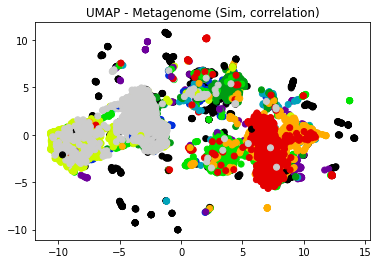

In [63]:
plot_meta(u_embedding, 'correlation')

In [58]:
tsne = TSNE(n_jobs=4)
t_embedding = tsne.fit_transform(pentamer_array)

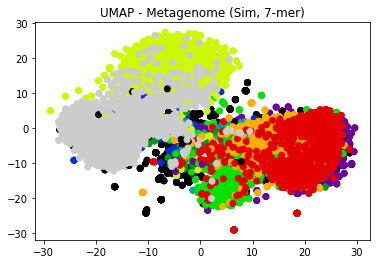

In [64]:
plot_meta(t_embedding, '7-mer')

In [60]:
np.save('septamer.npy', septamer_array)
np.save('pentamer.npy', pentamer_array)

In [30]:
def umap_embed_sept(neighbors, metric):
    u_embedding = umap.UMAP(n_neighbors=10,
                          min_dist=0.3,
                          metric='minkowski').fit_transform(septamer_array)
    return u_embedding

def tsne_embed_fun_sept():
    tsne = TSNE(n_jobs=4)
    return tsne.fit_transform(septamer_array)

def run_nonsense_sept(neighbors):
    u_euc_scores = []
    u_mah_scores = []
    u_cor_scores = []
    tsne_scores = []

    for i in range(5):
        euc_embed = umap_embed_sept(neighbors, 'euclidean')
        u_euc_scores.append(train_and_score(euc_embed, 0.4, 'rbf'))

        mah_embed = umap_embed_sept(neighbors, 'mahalanobis')
        u_mah_scores.append(train_and_score(mah_embed, 0.4, 'rbf'))

        cor_embed = umap_embed_sept(neighbors, 'correlation')
        u_cor_scores.append(train_and_score(cor_embed, 0.4, 'rbf'))

        tsne_embedding = tsne_embed_fun_sept()
        tsne_scores.append(train_and_score(tsne_embedding, 0.4, 'rbf'))
        print("loop " + str(i) + " complete.")
    return u_euc_scores, u_mah_scores, u_cor_scores, tsne_scores
    

In [31]:
euc_scores_15, mah_scores_15, cor_scores_15, tsne_scores = run_nonsense_sept(15)
print("Euclidean mean (15 neighbors): ", mean(euc_scores_15))
print("Mahalanobis mean (15 neighbors): ", mean(mah_scores_15))
print("Correlation mean (15 neighbors): ", mean(cor_scores_15))
print("tSNE mean: ", mean(tsne_scores))
#print(u_euc_scores[0:5])
#print(tsne_scores[0:5])

loop 0 complete.
loop 1 complete.
loop 2 complete.
loop 3 complete.
loop 4 complete.
Euclidean mean (15 neighbors):  0.8181499761184525
Mahalanobis mean (15 neighbors):  0.8187868173857666
Correlation mean (15 neighbors):  0.8231173380035027
tSNE mean:  0.7601018946027702


In [32]:
euc_scores_25, mah_scores_25, cor_scores_25, tsne_scores = run_nonsense_sept(25)
print("Euclidean mean (15 neighbors): ", mean(euc_scores_25))
print("Mahalanobis mean (15 neighbors): ", mean(mah_scores_25))
print("Correlation mean (15 neighbors): ", mean(cor_scores_25))
print("tSNE mean: ", mean(tsne_scores))

loop 0 complete.
loop 1 complete.
loop 2 complete.
loop 3 complete.
loop 4 complete.
Euclidean mean (15 neighbors):  0.8127368253462824
Mahalanobis mean (15 neighbors):  0.8162712943798759
Correlation mean (15 neighbors):  0.8096163031364432
tSNE mean:  0.7607387358700843


In [33]:
euc_scores_5, mah_scores_5, cor_scores_5, tsne_scores = run_nonsense_sept(5)
print("Euclidean mean (15 neighbors): ", mean(euc_scores_5))
print("Mahalanobis mean (15 neighbors): ", mean(mah_scores_5))
print("Correlation mean (15 neighbors): ", mean(cor_scores_5))
print("tSNE mean: ", mean(tsne_scores))

loop 0 complete.
loop 1 complete.
loop 2 complete.
loop 3 complete.
loop 4 complete.
Euclidean mean (15 neighbors):  0.8122910364591626
Mahalanobis mean (15 neighbors):  0.8120362999522369
Correlation mean (15 neighbors):  0.8095526190097118
tSNE mean:  0.759146632701799
